In [1]:
%run ../notebooks/00_setup_paths.ipynb

from spark_init import init_spark
spark = init_spark("Phase5_UnderReportCRIME", driver_memory="12g")
spark

utils/ folder added to Python import path
project_root:     C:\Users\akaas\crime-projectMain
raw_dir:          C:\Users\akaas\crime-projectMain\data
parquet_dir:      C:\Users\akaas\crime-projectMain\data_parquet
processed_dir:    C:\Users\akaas\crime-projectMain\data_processed
models_dir:       C:\Users\akaas\crime-projectMain\models
logs_dir:         C:\Users\akaas\crime-projectMain\logs
utils_dir:        C:\Users\akaas\crime-projectMain\utils
Spark Initialized: Phase5_UnderReportCRIME


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from prophet import Prophet
import statsmodels.api as sm
from pykalman import KalmanFilter

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")


In [3]:
phase4_dir = processed_dir / "phase4_timeseries"

df = spark.read.parquet(str(phase4_dir))
df_spark = df.toPandas()

print("Loaded Phase 4 data:", df_spark.shape)
df_spark.head()


Loaded Phase 4 data: (1114330, 14)


,ori,state,year,month,total_crimes,total_victims,total_property_loss,roll3,roll6,roll12,lag1,lag2,month_sin,month_cos
0,AK0010900,alaska,2019,4,1,1,NaN,1.000000,1.00,1.00,NaN,NaN,0.866023,-0.500004
1,AK0010900,alaska,2020,8,1,1,1330.0,1.000000,1.00,1.00,1.0,NaN,-0.866030,-0.499992
2,AK0010900,alaska,2020,12,1,1,1115.0,1.000000,1.00,1.00,1.0,1.0,0.000015,1.000000
3,AK0010900,alaska,2021,1,8,8,13025.0,3.333333,2.75,2.75,1.0,1.0,0.500001,0.866025
4,AK0010900,alaska,2021,2,5,5,2365.0,4.666667,3.20,3.20,8.0,1.0,0.866027,0.499998


In [5]:
ori_totals = (
    df_spark.groupby("ori")["total_crimes"].sum()
    .sort_values(ascending=False)
)

TOP_ORIS = ori_totals.head(50).index.tolist()
print("Top 50 ORIs loaded.")


Top 50 ORIs loaded.


In [6]:
crime_df = df_spark[df_spark["ori"].isin(TOP_ORIS)].copy()

# create date column
crime_df["date"] = pd.to_datetime(
    crime_df["year"].astype(str) + "-" + crime_df["month"].astype(str) + "-01"
)

crime_df = crime_df.sort_values(["ori", "date"]).reset_index(drop=True)
crime_df.head()

,ori,state,year,month,total_crimes,total_victims,total_property_loss,roll3,roll6,roll12,lag1,lag2,month_sin,month_cos,date
0,AR0600200,arkansas,2013,1,10,11,45608.0,10.000000,10.000000,10.000000,NaN,NaN,0.500001,0.866025,2013-01-01
1,AR0600200,arkansas,2013,2,3,4,5000.0,6.500000,6.500000,6.500000,10.0,NaN,0.866027,0.499998,2013-02-01
2,AR0600200,arkansas,2013,3,10,10,3660.0,7.666667,7.666667,7.666667,3.0,10.0,1.000000,-0.000004,2013-03-01
3,AR0600200,arkansas,2013,4,3,3,54894.0,5.333333,6.500000,6.500000,10.0,3.0,0.866023,-0.500004,2013-04-01
4,AR0600200,arkansas,2013,5,2,2,2000.0,5.000000,5.600000,5.600000,3.0,10.0,0.499995,-0.866028,2013-05-01


In [7]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

GT_KEYWORDS = ["crime", "shooting", "violence", "robbery"]

def load_trends_for_city(ori):
    city_df = crime_df[crime_df["ori"] == ori]
    dates = city_df["date"]

    pytrends.build_payload(GT_KEYWORDS, timeframe="2004-01-01 2025-01-01")

    trends = pytrends.interest_over_time().reset_index()
    trends = trends.rename(columns={"date": "date_gt"})

    return trends

In [8]:
all_trends = load_trends_for_city(TOP_ORIS[0])

crime_df = crime_df.merge(
    all_trends.rename(columns={"date_gt": "date"}),
    on="date",
    how="left"
)

crime_df.head()

,ori,state,year,month,total_crimes,total_victims,total_property_loss,roll3,roll6,roll12,lag1,lag2,month_sin,month_cos,date,crime,shooting,violence,robbery,isPartial
0,AR0600200,arkansas,2013,1,10,11,45608.0,10.000000,10.000000,10.000000,NaN,NaN,0.500001,0.866025,2013-01-01,19,34,6,3,False
1,AR0600200,arkansas,2013,2,3,4,5000.0,6.500000,6.500000,6.500000,10.0,NaN,0.866027,0.499998,2013-02-01,18,26,7,2,False
2,AR0600200,arkansas,2013,3,10,10,3660.0,7.666667,7.666667,7.666667,3.0,10.0,1.000000,-0.000004,2013-03-01,19,22,7,2,False
3,AR0600200,arkansas,2013,4,3,3,54894.0,5.333333,6.500000,6.500000,10.0,3.0,0.866023,-0.500004,2013-04-01,19,26,7,3,False
4,AR0600200,arkansas,2013,5,2,2,2000.0,5.000000,5.600000,5.600000,3.0,10.0,0.499995,-0.866028,2013-05-01,19,20,6,2,False


In [9]:
np.random.seed(42)
crime_df["service_311"] = (
    crime_df["total_crimes"] * 0.2
    + np.random.randint(0, 15, size=len(crime_df))
)

In [33]:
import xgboost as xgb

def train_prophet(ts):
    df = ts.rename(columns={"date": "ds", "total_crimes": "y"})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=3, freq="MS")
    forecast = m.predict(future)
    return forecast["yhat"][-3:].values

def train_sarimax(ts):
    model = sm.tsa.statespace.SARIMAX(
        ts["total_crimes"],
        order=(1,1,1),
        seasonal_order=(1,1,1,12),
        enforce_stationarity=False
    )
    res = model.fit()
    forecast = res.forecast(3)
    return forecast.values

def train_kalman(ts):
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
    )
    kf = kf.em(ts["total_crimes"].values, n_iter=20)
    smoothed, _ = kf.smooth(ts["total_crimes"].values)
    return smoothed[-3:].flatten()

def train_xgb(X_train, y_train, X_test, rounds=1200):
    model = xgb.XGBRegressor(
        n_estimators=1200,     # more trees
        learning_rate=0.03,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        tree_method="hist",
        verbose=400,
    )
    model.fit(X_train, y_train)
    return model.predict(X_test)

def train_catboost(X_train, y_train, X_test):
    model = CatBoostRegressor(
        iterations=1200,       # increase iterations
        learning_rate=0.03,    # smaller LR improves quality
        depth=8,
        loss_function="RMSE",
        verbose=400,
    )
    model.fit(X_train, y_train)
    return model.predict(X_test)


def train_lstm(series):
    # Convert to numpy array
    series = np.array(series).astype(float)
    series = series.reshape(-1, 1)

    # Scale the values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)

    # Prepare supervised format (2 timesteps → 1 output)
    X, y = [], []
    for i in range(2, len(scaled)):
        X.append(scaled[i-2:i].reshape(2, 1))
        y.append(scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Build LSTM model
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(2, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=25, verbose=0)

    # ------------ PREDICT NEXT 3 MONTHS -------------
    last_two = scaled[-2:].reshape(1, 2, 1)

    preds_scaled = []
    prev = last_two.copy()

    for _ in range(3):
        next_pred = model.predict(prev, verbose=0)[0][0]    # ALWAYS SCALAR
        preds_scaled.append(next_pred)

        # shift window (ensure shape is correct: (1,2,1))
        prev = np.array([[prev[0][1][0], next_pred]]).reshape(1, 2, 1)

    # Convert back to original scale
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    return preds


In [34]:
results = []

for ori in TOP_ORIS:
    ts = crime_df[crime_df["ori"] == ori].copy()
    if len(ts) < 24:
        continue

    X_train = ts[["roll3", "roll6", "roll12", "lag1", "lag2"]].iloc[:-3].fillna(0)
    y_train = ts["total_crimes"].iloc[:-3]
    X_test  = ts[["roll3", "roll6", "roll12", "lag1", "lag2"]].iloc[-3:].fillna(0)

    preds_prophet = train_prophet(ts)
    preds_sarimax = train_sarimax(ts)
    preds_kalman  = train_kalman(ts)
    preds_xgb = train_xgb(X_train, y_train, X_test)
    preds_cat = train_catboost(X_train, y_train, X_test)
    preds_lstm = train_lstm(ts["total_crimes"].values)

    ensemble = (
        preds_prophet +
        preds_sarimax +
        preds_kalman +
        preds_xgb +
        preds_cat +
        preds_lstm
    ) / 6

    # actual
    actual = ts["total_crimes"].iloc[-3:].values

    for i, d in enumerate(ts["date"].iloc[-3:]):
        results.append({
            "ori": ori,
            "date": d,
            "expected": ensemble[i],
            "actual": actual[i],
            "under_reporting": ensemble[i] - actual[i]
        })
print("Completed")

04:54:12 - cmdstanpy - INFO - Chain [1] start processing
04:54:12 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 821.1472700	total: 1.28ms	remaining: 1.53s
400:	learn: 59.1951316	total: 349ms	remaining: 695ms
800:	learn: 10.6038962	total: 696ms	remaining: 347ms
1199:	learn: 2.2317019	total: 1.05s	remaining: 0us


04:54:15 - cmdstanpy - INFO - Chain [1] start processing
04:54:15 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 18913.5104334	total: 382us	remaining: 458ms
400:	learn: 345.3174979	total: 320ms	remaining: 638ms
800:	learn: 119.0112429	total: 654ms	remaining: 326ms
1199:	learn: 52.7393754	total: 1.01s	remaining: 0us


04:54:18 - cmdstanpy - INFO - Chain [1] start processing
04:54:18 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 2158.5264641	total: 1.94ms	remaining: 2.32s
400:	learn: 141.7947193	total: 553ms	remaining: 1.1s
800:	learn: 51.3187682	total: 1.09s	remaining: 544ms
1199:	learn: 21.2399510	total: 1.64s	remaining: 0us


04:54:23 - cmdstanpy - INFO - Chain [1] start processing
04:54:23 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1761.9384323	total: 1.8ms	remaining: 2.16s
400:	learn: 101.0584198	total: 552ms	remaining: 1.1s
800:	learn: 31.0336279	total: 1.12s	remaining: 556ms
1199:	learn: 11.7475859	total: 1.66s	remaining: 0us


04:54:27 - cmdstanpy - INFO - Chain [1] start processing
04:54:27 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 3526.8306059	total: 1.22ms	remaining: 1.46s
400:	learn: 369.7280359	total: 293ms	remaining: 583ms
800:	learn: 57.3328414	total: 594ms	remaining: 296ms
1199:	learn: 12.8787404	total: 904ms	remaining: 0us


04:54:30 - cmdstanpy - INFO - Chain [1] start processing
04:54:30 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1533.4323826	total: 2.16ms	remaining: 2.59s
400:	learn: 87.7788270	total: 614ms	remaining: 1.22s
800:	learn: 27.4956336	total: 1.24s	remaining: 616ms
1199:	learn: 11.3914507	total: 1.8s	remaining: 0us


04:54:35 - cmdstanpy - INFO - Chain [1] start processing
04:54:35 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1589.7953809	total: 2ms	remaining: 2.4s
400:	learn: 94.8846385	total: 558ms	remaining: 1.11s
800:	learn: 31.3644623	total: 1.1s	remaining: 549ms
1199:	learn: 12.3278120	total: 1.65s	remaining: 0us


04:54:39 - cmdstanpy - INFO - Chain [1] start processing
04:54:39 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1526.0434726	total: 2.02ms	remaining: 2.42s
400:	learn: 137.8807609	total: 454ms	remaining: 904ms
800:	learn: 31.6731021	total: 990ms	remaining: 493ms
1199:	learn: 10.1405526	total: 1.59s	remaining: 0us


04:54:44 - cmdstanpy - INFO - Chain [1] start processing
04:54:44 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 536.1666934	total: 1.56ms	remaining: 1.87s
400:	learn: 40.5518530	total: 387ms	remaining: 771ms
800:	learn: 7.6437046	total: 764ms	remaining: 381ms
1199:	learn: 1.6672049	total: 1.15s	remaining: 0us


04:54:48 - cmdstanpy - INFO - Chain [1] start processing
04:54:48 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1606.7900351	total: 1.83ms	remaining: 2.19s
400:	learn: 130.6353237	total: 609ms	remaining: 1.21s
800:	learn: 53.6981831	total: 1.18s	remaining: 586ms
1199:	learn: 22.7544302	total: 1.78s	remaining: 0us


04:54:52 - cmdstanpy - INFO - Chain [1] start processing
04:54:52 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1874.0893558	total: 1.15ms	remaining: 1.38s
400:	learn: 223.0115104	total: 296ms	remaining: 589ms
800:	learn: 32.4435538	total: 608ms	remaining: 303ms
1199:	learn: 7.3152510	total: 920ms	remaining: 0us


04:54:55 - cmdstanpy - INFO - Chain [1] start processing
04:54:55 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1215.4126744	total: 1.94ms	remaining: 2.32s
400:	learn: 79.0227926	total: 519ms	remaining: 1.03s
800:	learn: 21.6634801	total: 1.07s	remaining: 536ms
1199:	learn: 7.6130560	total: 1.6s	remaining: 0us


04:55:00 - cmdstanpy - INFO - Chain [1] start processing
04:55:00 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1529.7439255	total: 1.96ms	remaining: 2.35s
400:	learn: 112.7856778	total: 592ms	remaining: 1.18s
800:	learn: 40.0645084	total: 1.17s	remaining: 585ms
1199:	learn: 17.1374670	total: 1.73s	remaining: 0us


04:55:05 - cmdstanpy - INFO - Chain [1] start processing
04:55:05 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1111.9805824	total: 1.01ms	remaining: 1.21s
400:	learn: 77.9178353	total: 279ms	remaining: 556ms
800:	learn: 11.7308140	total: 549ms	remaining: 273ms
1199:	learn: 2.0797191	total: 813ms	remaining: 0us


04:55:07 - cmdstanpy - INFO - Chain [1] start processing
04:55:08 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 451.9784133	total: 1.58ms	remaining: 1.9s
400:	learn: 60.0585273	total: 428ms	remaining: 852ms
800:	learn: 14.1622362	total: 871ms	remaining: 434ms
1199:	learn: 3.6783621	total: 1.31s	remaining: 0us


04:55:11 - cmdstanpy - INFO - Chain [1] start processing
04:55:11 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1224.4828486	total: 1.86ms	remaining: 2.23s
400:	learn: 98.3829028	total: 557ms	remaining: 1.11s
800:	learn: 34.2099932	total: 1.11s	remaining: 553ms
1199:	learn: 13.2304745	total: 1.68s	remaining: 0us


04:55:16 - cmdstanpy - INFO - Chain [1] start processing
04:55:16 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1278.5497185	total: 2.1ms	remaining: 2.52s
400:	learn: 92.1587129	total: 577ms	remaining: 1.15s
800:	learn: 26.5331703	total: 1.19s	remaining: 594ms
1199:	learn: 8.8020110	total: 1.81s	remaining: 0us


04:55:21 - cmdstanpy - INFO - Chain [1] start processing
04:55:21 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1137.9007850	total: 1.58ms	remaining: 1.89s
400:	learn: 73.6854416	total: 545ms	remaining: 1.09s
800:	learn: 24.0174419	total: 1.12s	remaining: 560ms
1199:	learn: 9.7123307	total: 1.74s	remaining: 0us


04:55:25 - cmdstanpy - INFO - Chain [1] start processing
04:55:25 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1055.2356326	total: 2.24ms	remaining: 2.68s
400:	learn: 65.6110474	total: 601ms	remaining: 1.2s
800:	learn: 20.8740099	total: 1.28s	remaining: 637ms
1199:	learn: 7.8143967	total: 1.84s	remaining: 0us


04:55:30 - cmdstanpy - INFO - Chain [1] start processing
04:55:30 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 4279.2611959	total: 1.38ms	remaining: 1.65s
400:	learn: 99.4959512	total: 383ms	remaining: 764ms
800:	learn: 24.3689535	total: 763ms	remaining: 380ms
1199:	learn: 8.0954539	total: 1.12s	remaining: 0us


04:55:34 - cmdstanpy - INFO - Chain [1] start processing
04:55:34 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 3470.5499134	total: 1.4ms	remaining: 1.68s
400:	learn: 112.6756878	total: 360ms	remaining: 717ms
800:	learn: 33.2721162	total: 712ms	remaining: 355ms
1199:	learn: 10.1150243	total: 1.05s	remaining: 0us


04:55:38 - cmdstanpy - INFO - Chain [1] start processing
04:55:38 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 471.8103819	total: 1.25ms	remaining: 1.5s
400:	learn: 38.5622619	total: 366ms	remaining: 729ms
800:	learn: 7.0953994	total: 767ms	remaining: 382ms
1199:	learn: 1.5271440	total: 1.16s	remaining: 0us


  0%|          | 0/1200 [06:35<?, ?it/s]
04:55:43 - cmdstanpy - INFO - Chain [1] start processing
04:55:43 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 431.0214037	total: 1.22ms	remaining: 1.47s
400:	learn: 35.2595223	total: 353ms	remaining: 704ms
800:	learn: 7.0663321	total: 728ms	remaining: 363ms
1199:	learn: 1.5561878	total: 1.07s	remaining: 0us


04:55:46 - cmdstanpy - INFO - Chain [1] start processing
04:55:46 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 394.4936178	total: 1.65ms	remaining: 1.98s
400:	learn: 36.6002529	total: 448ms	remaining: 892ms
800:	learn: 8.3538545	total: 888ms	remaining: 442ms
1199:	learn: 2.3234097	total: 1.3s	remaining: 0us


04:55:51 - cmdstanpy - INFO - Chain [1] start processing
04:55:51 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 818.5564775	total: 1.97ms	remaining: 2.36s
400:	learn: 41.0079741	total: 568ms	remaining: 1.13s
800:	learn: 12.0436279	total: 1.12s	remaining: 557ms
1199:	learn: 4.6217015	total: 1.7s	remaining: 0us


04:55:55 - cmdstanpy - INFO - Chain [1] start processing
04:55:55 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1534.7913515	total: 1.46ms	remaining: 1.75s
400:	learn: 55.1986652	total: 374ms	remaining: 746ms
800:	learn: 10.8137653	total: 735ms	remaining: 366ms
1199:	learn: 2.6096037	total: 1.07s	remaining: 0us


04:55:59 - cmdstanpy - INFO - Chain [1] start processing
04:55:59 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 709.5571055	total: 2.02ms	remaining: 2.43s
400:	learn: 40.8693569	total: 583ms	remaining: 1.16s
800:	learn: 10.7252239	total: 1.11s	remaining: 554ms
1199:	learn: 3.3101540	total: 1.65s	remaining: 0us


04:56:03 - cmdstanpy - INFO - Chain [1] start processing
04:56:03 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 691.1533918	total: 2.11ms	remaining: 2.53s
400:	learn: 44.5598360	total: 623ms	remaining: 1.24s
800:	learn: 15.0649534	total: 1.22s	remaining: 605ms
1199:	learn: 5.6718093	total: 1.78s	remaining: 0us


04:56:08 - cmdstanpy - INFO - Chain [1] start processing
04:56:09 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1288.0368066	total: 1.47ms	remaining: 1.76s
400:	learn: 81.6641443	total: 505ms	remaining: 1s
800:	learn: 25.6626660	total: 991ms	remaining: 494ms
1199:	learn: 10.9506870	total: 1.45s	remaining: 0us


04:56:12 - cmdstanpy - INFO - Chain [1] start processing
04:56:12 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 640.6073570	total: 1.89ms	remaining: 2.26s
400:	learn: 40.2226089	total: 549ms	remaining: 1.09s
800:	learn: 13.6946707	total: 1.07s	remaining: 533ms
1199:	learn: 5.5012912	total: 1.52s	remaining: 0us


04:56:17 - cmdstanpy - INFO - Chain [1] start processing
04:56:17 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 645.5546918	total: 1.7ms	remaining: 2.04s
400:	learn: 51.9791758	total: 532ms	remaining: 1.06s
800:	learn: 20.5186778	total: 1.1s	remaining: 547ms
1199:	learn: 9.0747798	total: 1.65s	remaining: 0us


04:56:21 - cmdstanpy - INFO - Chain [1] start processing
04:56:21 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 636.1191800	total: 1.95ms	remaining: 2.34s
400:	learn: 49.0882236	total: 547ms	remaining: 1.09s
800:	learn: 15.3727830	total: 1.11s	remaining: 551ms
1199:	learn: 6.0875851	total: 1.69s	remaining: 0us


04:56:25 - cmdstanpy - INFO - Chain [1] start processing
04:56:26 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 417.5016797	total: 1.2ms	remaining: 1.44s
400:	learn: 50.1735921	total: 343ms	remaining: 684ms
800:	learn: 10.0280535	total: 693ms	remaining: 345ms
1199:	learn: 2.5358076	total: 1.04s	remaining: 0us


04:56:29 - cmdstanpy - INFO - Chain [1] start processing
04:56:29 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 561.7819911	total: 2ms	remaining: 2.4s
400:	learn: 42.1330809	total: 573ms	remaining: 1.14s
800:	learn: 12.9163275	total: 1.14s	remaining: 566ms
1199:	learn: 4.6296912	total: 1.68s	remaining: 0us


04:56:33 - cmdstanpy - INFO - Chain [1] start processing
04:56:34 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1438.9138330	total: 1.67ms	remaining: 2s
400:	learn: 65.4987346	total: 430ms	remaining: 856ms
800:	learn: 22.9663188	total: 854ms	remaining: 425ms
1199:	learn: 8.7417363	total: 1.3s	remaining: 0us


04:56:37 - cmdstanpy - INFO - Chain [1] start processing
04:56:37 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 506.3499049	total: 1.93ms	remaining: 2.31s
400:	learn: 41.0707904	total: 535ms	remaining: 1.07s
800:	learn: 13.4182902	total: 1.08s	remaining: 538ms
1199:	learn: 5.0527100	total: 1.63s	remaining: 0us


04:56:42 - cmdstanpy - INFO - Chain [1] start processing
04:56:42 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 332.6344850	total: 1.15ms	remaining: 1.37s
400:	learn: 26.7052922	total: 276ms	remaining: 549ms
800:	learn: 2.1747246	total: 552ms	remaining: 275ms
1199:	learn: 0.2855659	total: 834ms	remaining: 0us


04:56:45 - cmdstanpy - INFO - Chain [1] start processing
04:56:45 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 711.8428149	total: 1.61ms	remaining: 1.93s
400:	learn: 28.1591350	total: 452ms	remaining: 900ms
800:	learn: 7.0987902	total: 943ms	remaining: 470ms
1199:	learn: 2.2556859	total: 1.4s	remaining: 0us


04:56:49 - cmdstanpy - INFO - Chain [1] start processing
04:56:49 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 484.0226587	total: 1.88ms	remaining: 2.25s
400:	learn: 30.5600608	total: 575ms	remaining: 1.15s
800:	learn: 9.1888261	total: 1.16s	remaining: 578ms
1199:	learn: 3.4870489	total: 1.78s	remaining: 0us


04:56:54 - cmdstanpy - INFO - Chain [1] start processing
04:56:54 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 2511.8563355	total: 433us	remaining: 520ms
400:	learn: 85.8598427	total: 276ms	remaining: 550ms
800:	learn: 21.7686272	total: 562ms	remaining: 280ms
1199:	learn: 4.9581460	total: 860ms	remaining: 0us


04:56:57 - cmdstanpy - INFO - Chain [1] start processing
04:56:57 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 486.1027607	total: 2.15ms	remaining: 2.57s
400:	learn: 44.2056167	total: 620ms	remaining: 1.23s
800:	learn: 16.1063050	total: 1.24s	remaining: 618ms
1199:	learn: 6.4540600	total: 1.87s	remaining: 0us


04:57:01 - cmdstanpy - INFO - Chain [1] start processing
04:57:02 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 1727.2104367	total: 1.42ms	remaining: 1.71s
400:	learn: 62.9603004	total: 322ms	remaining: 642ms
800:	learn: 13.2698067	total: 644ms	remaining: 321ms
1199:	learn: 3.5528740	total: 972ms	remaining: 0us


04:57:05 - cmdstanpy - INFO - Chain [1] start processing
04:57:05 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 445.0641481	total: 2.03ms	remaining: 2.44s
400:	learn: 31.2335303	total: 527ms	remaining: 1.05s
800:	learn: 9.7215482	total: 1.15s	remaining: 571ms
1199:	learn: 3.7394778	total: 1.78s	remaining: 0us


04:57:10 - cmdstanpy - INFO - Chain [1] start processing
04:57:10 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 685.9801437	total: 1.86ms	remaining: 2.23s
400:	learn: 32.6418290	total: 513ms	remaining: 1.02s
800:	learn: 9.5628012	total: 1.01s	remaining: 502ms
1199:	learn: 3.6509041	total: 1.5s	remaining: 0us


04:57:14 - cmdstanpy - INFO - Chain [1] start processing
04:57:14 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 293.0586340	total: 1.62ms	remaining: 1.94s
400:	learn: 25.7375134	total: 456ms	remaining: 909ms
800:	learn: 6.4995625	total: 917ms	remaining: 457ms
1199:	learn: 2.1354567	total: 1.38s	remaining: 0us


04:57:18 - cmdstanpy - INFO - Chain [1] start processing
04:57:18 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 450.3418613	total: 2ms	remaining: 2.39s
400:	learn: 30.3241757	total: 587ms	remaining: 1.17s
800:	learn: 8.8948969	total: 1.19s	remaining: 593ms
1199:	learn: 3.0955759	total: 1.8s	remaining: 0us


04:57:22 - cmdstanpy - INFO - Chain [1] start processing
04:57:22 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 477.5719933	total: 2.28ms	remaining: 2.74s
400:	learn: 36.1976659	total: 624ms	remaining: 1.24s
800:	learn: 12.4095996	total: 1.23s	remaining: 614ms
1199:	learn: 5.0944035	total: 1.84s	remaining: 0us


04:57:27 - cmdstanpy - INFO - Chain [1] start processing
04:57:27 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 444.7951554	total: 1.91ms	remaining: 2.29s
400:	learn: 34.4367620	total: 586ms	remaining: 1.17s
800:	learn: 12.1262712	total: 1.21s	remaining: 601ms
1199:	learn: 4.8463504	total: 1.8s	remaining: 0us


04:57:32 - cmdstanpy - INFO - Chain [1] start processing
04:57:32 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 483.7372799	total: 1.82ms	remaining: 2.18s
400:	learn: 40.8061438	total: 538ms	remaining: 1.07s
800:	learn: 13.3602012	total: 1.11s	remaining: 554ms
1199:	learn: 5.4563005	total: 1.67s	remaining: 0us


04:57:37 - cmdstanpy - INFO - Chain [1] start processing
04:57:37 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 277.7698308	total: 1.53ms	remaining: 1.84s
400:	learn: 22.3689964	total: 417ms	remaining: 831ms
800:	learn: 5.7090090	total: 830ms	remaining: 413ms
1199:	learn: 1.7795756	total: 1.25s	remaining: 0us
Completed


In [35]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

xgb_metrics = []
cat_metrics = []

for ori in TOP_ORIS:
    ts = crime_df[crime_df["ori"] == ori].copy()
    if len(ts) < 24:
        continue

    X_train = ts[["roll3", "roll6", "roll12", "lag1", "lag2"]].iloc[:-3].fillna(0)
    y_train = ts["total_crimes"].iloc[:-3]
    X_test  = ts[["roll3", "roll6", "roll12", "lag1", "lag2"]].iloc[-3:].fillna(0)
    y_test  = ts["total_crimes"].iloc[-3:].values

    # XGBoost predictions
    preds_xgb = train_xgb(X_train, y_train, X_test)

    # CatBoost predictions
    preds_cat = train_catboost(X_train, y_train, X_test)

    # METRICS FOR XGBOOST
    mae_x = mean_absolute_error(y_test, preds_xgb)
    rmse_x = np.sqrt(mean_squared_error(y_test, preds_xgb))
    mape_x = np.mean(np.abs((y_test - preds_xgb) / y_test)) * 100
    r2_x = r2_score(y_test, preds_xgb)
    accuracy_x = 100 - mape_x

    xgb_metrics.append([ori, mae_x, rmse_x, mape_x, accuracy_x, r2_x])

    # METRICS FOR CATBOOST
    mae_c = mean_absolute_error(y_test, preds_cat)
    rmse_c = np.sqrt(mean_squared_error(y_test, preds_cat))
    mape_c = np.mean(np.abs((y_test - preds_cat) / y_test)) * 100
    r2_c = r2_score(y_test, preds_cat)
    accuracy_c = 100 - mape_c

    cat_metrics.append([ori, mae_c, rmse_c, mape_c, accuracy_c, r2_c])

import pandas as pd

xgb_df = pd.DataFrame(xgb_metrics, columns=["ori", "MAE", "RMSE", "MAPE", "Accuracy(%)", "R2"])
cat_df = pd.DataFrame(cat_metrics, columns=["ori", "MAE", "RMSE", "MAPE", "Accuracy(%)", "R2"])

print("=== XGBoost Accuracy ===")
display(xgb_df.head())

print("=== CatBoost Accuracy ===")
display(cat_df.head())


0:	learn: 821.1472700	total: 1.48ms	remaining: 1.77s
400:	learn: 59.1951316	total: 409ms	remaining: 815ms
800:	learn: 10.6038962	total: 819ms	remaining: 408ms
1199:	learn: 2.2317019	total: 1.21s	remaining: 0us
0:	learn: 18913.5104334	total: 426us	remaining: 511ms
400:	learn: 345.3174979	total: 358ms	remaining: 713ms
800:	learn: 119.0112429	total: 728ms	remaining: 363ms
1199:	learn: 52.7393754	total: 1.09s	remaining: 0us
0:	learn: 2158.5264641	total: 1.95ms	remaining: 2.34s
400:	learn: 141.7947193	total: 614ms	remaining: 1.22s
800:	learn: 51.3187682	total: 1.23s	remaining: 612ms
1199:	learn: 21.2399510	total: 1.84s	remaining: 0us
0:	learn: 1761.9384323	total: 2.08ms	remaining: 2.5s
400:	learn: 101.0584198	total: 665ms	remaining: 1.32s
800:	learn: 31.0336279	total: 1.3s	remaining: 649ms
1199:	learn: 11.7475859	total: 1.95s	remaining: 0us
0:	learn: 3526.8306059	total: 1.29ms	remaining: 1.55s
400:	learn: 369.7280359	total: 245ms	remaining: 489ms
800:	learn: 57.3328414	total: 531ms	remainin

,ori,MAE,RMSE,MAPE,Accuracy(%),R2
0,TXHPD0000,365.304688,433.511011,2.328171,97.671829,0.042737
1,NY0303000,1868.820312,1917.302467,4.538008,95.461992,0.395835
2,TNMPD0000,255.240067,282.885536,3.637101,96.362899,0.315620
3,MI8234900,136.289062,152.331958,2.298619,97.701381,0.830976
4,ILCPD0000,1430.583374,1817.694075,8.124184,91.875816,-1.128606


=== CatBoost Accuracy ===


,ori,MAE,RMSE,MAPE,Accuracy(%),R2
0,TXHPD0000,314.719963,374.030454,2.008715,97.991285,0.287401
1,NY0303000,2283.465384,2437.812672,5.590672,94.409328,0.023269
2,TNMPD0000,207.747445,239.157088,2.983052,97.016948,0.510850
3,MI8234900,87.961222,89.166195,1.439999,98.560001,0.942088
4,ILCPD0000,1371.204858,1602.722806,7.765802,92.234198,-0.654896


In [36]:
results_df = pd.DataFrame(results)
display(results_df.head())

,ori,date,expected,actual,under_reporting
0,TXHPD0000,2024-10-01,16228.944925,16464,-235.055075
1,TXHPD0000,2024-11-01,15508.937115,15384,124.937115
2,TXHPD0000,2024-12-01,16182.053581,16017,165.053581
3,NY0303000,2024-10-01,38318.593777,44962,-6643.406223
4,NY0303000,2024-11-01,37577.669063,41674,-4096.330937


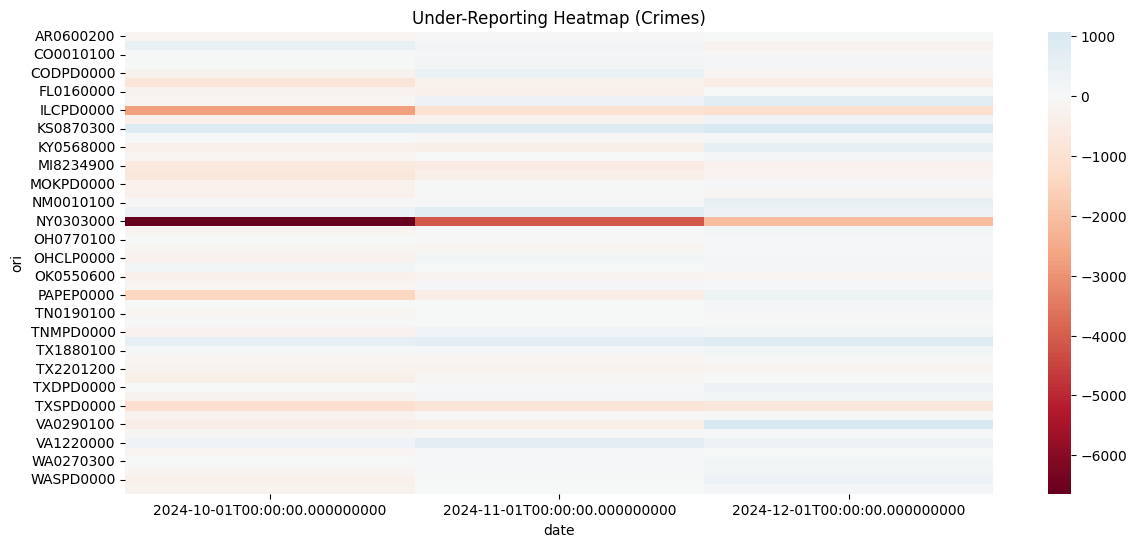

In [37]:
plt.figure(figsize=(14,6))
heat = results_df.pivot(index="ori", columns="date", values="under_reporting")
sns.heatmap(heat, cmap="RdBu", center=0)
plt.title("Under-Reporting Heatmap (Crimes)")
plt.show()

In [38]:
out_dir = processed_dir / "phase5_underreporting" / "crimes"
out_dir.mkdir(parents=True, exist_ok=True)

results_df.to_csv(out_dir / "under_reporting_crimes.csv", index=False)

print("Saved:", out_dir)

Saved: C:\Users\akaas\crime-projectMain\data_processed\phase5_underreporting\crimes
